# Follower network
We start from the Twitter follower network constructed for the paper [Right and left, partisanship predicts (asymmetric) vulnerability to misinformation](http://doi.org/10.37016/mr-2020-55). The following data files are available at https://doi.org/10.7910/DVN/6CZHH5:
* `anonymized-friends.json` 
* `measures.tab`

Briefly, this network was constructed as follows:
* We collected all tweets containing links (URLs) from a 10% random sample of public posts between June 1 and June 30, 2017, through the Twitter Decahose. 
* We selected all accounts that shared at least ten links from a set of news sources with known political valence (Bakshy et al., 2015). 
* We further selected those who shared at least one link from a source labeled as low-quality (https://github.com/BigMcLargeHuge/opensources). 
* We excluded likely bot accounts according to the BotometerLite classifier (Yang et al., 2020).

We keep the nodes with both partisanship and misinformation attributes, then we take the core of the network with approximately 10k nodes, and finally remove a random sample of edges to preserve the original average in/out-degree (number of friends/followers).

In [1]:
import networkx as nx
import csv
import json
import random
import importlib
import bot_model

In [2]:
path = "../EmpiricalNet_followers/"

In [13]:
# File has 3 columns: ID \t partisanship \t misinformation \n
partisanship = {}
misinformation = {}
with open(path + "measures.tab") as fd:
    rd = csv.reader(fd, delimiter="\t")
    next(rd) # skip header row
    for row in rd:
        partisanship[int(row[0])] = row[1]
        misinformation[int(row[0])] = row[2]

In [14]:
with open(path + 'anonymized-friends.json') as fp:
    adjlist = json.load(fp)

In [15]:
G = nx.DiGraph() 

In [16]:
# Directed network follower -> friend
for s in adjlist:
    n = int(s)
    if n in partisanship and n in misinformation:
        G.add_node(n, party=partisanship[n], misinfo=misinformation[n]) 
        for f in adjlist[s]:
            G.add_edge(n,f)

In [17]:
average_friends = G.number_of_edges() / G.number_of_nodes()
print("{} nodes and {} edges initially, with average number of friends {}".format(G.number_of_nodes(), G.number_of_edges(), average_friends))
friends = nx.subgraph(G, partisanship.keys())
print("{} nodes and {} edges after filtering".format(friends.number_of_nodes(), friends.number_of_edges()))

58048 nodes and 10499218 edges initially, with average number of friends 180.87131339581038
15056 nodes and 4327448 edges after filtering


In [19]:
# k-core decomposition until ~ 10k nodes in core
core_number = nx.core_number(friends)
nodes = friends.number_of_nodes()
k = 0
while nodes > 10000:
    k_core = nx.k_core(friends, k, core_number)
    nodes = k_core.number_of_nodes()
    k += 10
while nodes < 10000:
    k_core = nx.k_core(friends, k, core_number)
    nodes = k_core.number_of_nodes()
    k -= 1
print("{}-core has {} nodes, {} edges".format(k, k_core.number_of_nodes(), k_core.number_of_edges()))

94-core has 10006 nodes, 4144687 edges


In [20]:
# the network is super dense, so let us delete a random sample of edges
# we can set the initial average in/out-degree (average_friends) as a target 
friends_core = k_core.copy()
edges_to_keep = int(friends_core.number_of_nodes() * average_friends)
edges_to_delete = friends_core.number_of_edges() - edges_to_keep
deleted_edges = random.sample(friends_core.edges(), edges_to_delete)
friends_core.remove_edges_from(deleted_edges)
print("{}-core after edge-sampling has {} nodes, {} edges, and average number of friends {}".format(k, friends_core.number_of_nodes(), friends_core.number_of_edges(), friends_core.number_of_edges() / friends_core.number_of_nodes()))

94-core after edge-sampling has 10006 nodes, 1809798 edges, and average number of friends 180.8712772336598


In [22]:
nx.write_gml(friends_core, path + 'follower_network.gml')

## Test

In [52]:
importlib.reload(bot_model)
follower_net = bot_model.init_net(False, verbose=True, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
avg_quality = bot_model.simulation(False, network=follower_net, verbose=True, mu=0.5, phi=1, alpha=15)
print('average quality for follower network:', avg_quality)

Reading human network...
Generating bot network...
Merging human and bot networks...
Humans following bots...
time_steps =  0 , q =  200
time_steps =  1 , q =  0.4801671070272221
time_steps =  2 , q =  0.4931137924415558
average quality for follower network: 0.49038907607976123


## Baseline

In [12]:
# baseline:  alpha=15, beta=0, gamma=0, phi=1, theta = 1

follower_net = bot_model.init_net(False, verbose=False, human_network = path + 'follower_network.gml', beta=0.0, gamma=0.0)
avg_quality_baseline = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15)
print('average quality baseline:', avg_quality_baseline)

average quality baseline: 0.4803009094579953


## Experiments with individual parameters
Params: alpha (15), beta (0.01), gamma (0.001), phi (1), theta (1), network density?

In [16]:
# run this when making changes to bot_model.py
importlib.reload(bot_model)

<module 'bot_model' from '/geode2/home/u030/fil/Carbonate/Xiaodan/Manipulating-Online-Marketplace-of-Ideas/bot_model.py'>

### Experiment: alpha (attention)

In [ ]:
# alpha=15 from test above
bot_model.save_csv([15, 0.49038907607976123], csvfile = path + 'alpha.csv')
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)

In [ ]:
# note: usied epsilon 0.01 for alpha in [5, 45, 135]
# more values with epsilon successively set to 0.001
for alpha in [2, 4, 8, 16, 32, 64, 128]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=alpha)
    print('alpha = {}, average quality = {}'.format(alpha, avg_quality))
    bot_model.save_csv([alpha, avg_quality], csvfile = path + 'alpha.csv')

### Experiment: beta (number of bots)

In [ ]:
# beta=0.01 from test above
bot_model.save_csv([0.01, 0.49038907607976123], csvfile = path + 'beta.csv')
for beta in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]:
    follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=beta, gamma=0.001)
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=True, mu=0.5, phi=1, alpha=15)
    print('beta = {}, average quality = {}'.format(beta, avg_quality))
    bot_model.save_csv([beta, avg_quality], csvfile = path + 'beta.csv')

### Experiment: gamma (infiltration)

In [14]:
# gamma=0.001 from test above
bot_model.save_csv([0.001, 0.49038907607976123], csvfile = path + 'gamma.csv')
for gamma in [0.0001, 0.0002, 0.0005, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
    follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15)
    print('gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma.csv')

gamma = 0.0001, average quality = 0.47590118989990104
gamma = 0.0002, average quality = 0.49110978933620475
gamma = 0.0005, average quality = 0.47974305280211854
gamma = 0.002, average quality = 0.47217610366333035
gamma = 0.005, average quality = 0.4803758950970987
gamma = 0.01, average quality = 0.44506330853745196
gamma = 0.02, average quality = 0.4291719118666293
gamma = 0.05, average quality = 0.3797217140462188
gamma = 0.1, average quality = 0.3530738102542187
gamma = 0.2, average quality = 0.30639434404347166
gamma = 0.5, average quality = 0.20927011102314436


### Experiment: phi (deception) 

In [ ]:
# phi=1 from test above
bot_model.save_csv([1, 0.49038907607976123], csvfile = path + 'phi.csv')
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
for phi in [2,4,8,16,32]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=True, mu=0.5, phi=phi, alpha=15)
    print('phi = {}, average quality = {}'.format(phi, avg_quality))
    bot_model.save_csv([phi, avg_quality], csvfile = path + 'phi.csv')

### Experiment: theta (flooding)
Effect visible with larger gamma; saturation with high theta

In [ ]:
# theta=1 from test above
bot_model.save_csv([1, 0.49038907607976123], csvfile = path + 'theta.csv')
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
for theta in [2,4,6,8,10,12,14]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15, theta=theta)
    print('theta = {}, average quality = {}'.format(theta, avg_quality))
    bot_model.save_csv([theta, avg_quality], csvfile = path + 'theta.csv')

## Experiments with parameter interactions
Stronger effects observed above for gamma, phi, theta

### Quality vs theta for increasing values of gamma

In [ ]:
# gamma = 0.01
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.01)
for theta in [1,2,4,6,8,10,12,14]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15, theta=theta)
    print('theta = {}, average quality = {}'.format(theta, avg_quality))
    bot_model.save_csv([theta, avg_quality], csvfile = path + 'theta_gamma0.01.csv')

In [ ]:
# gamma = 0.1
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.1)
for theta in [1,2,4,6,8,10,12,14]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15, theta=theta)
    print('theta = {}, average quality = {}'.format(theta, avg_quality))
    bot_model.save_csv([theta, avg_quality], csvfile = path + 'theta_gamma0.1.csv')

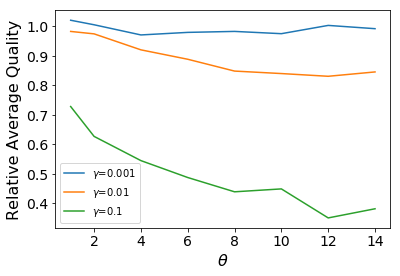

In [9]:
# PLOT AVG_Q vs THETA (flooding)
plot_avg_quality(['theta.csv', 'theta_gamma0.01.csv', 'theta_gamma0.1.csv'], 
                 [r'$\gamma$'+'=0.001', r'$\gamma$'+'=0.01', r'$\gamma$'+'=0.1'], 
                 r'$\theta$', path='../EmpiricalNet_followers/')

### Quality vs phi for increasing values of gamma

In [11]:
# gamma = 0.01
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.01)
for phi in [1,2,4,8,16,32]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=phi, alpha=15)
    print('phi = {}, average quality = {}'.format(phi, avg_quality))
    bot_model.save_csv([phi, avg_quality], csvfile = path + 'phi_gamma0.01.csv')

phi = 1, average quality = 0.44981665177018326
phi = 2, average quality = 0.3361073375808723
phi = 4, average quality = 0.13215003763279676
phi = 8, average quality = 0.06385999213984783
phi = 16, average quality = 0.030989196434527445
phi = 32, average quality = 0.015830294644505766


In [13]:
# gamma = 0.1
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.1)
for phi in [1,2,4,8,16,32]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=phi, alpha=15)
    print('phi = {}, average quality = {}'.format(phi, avg_quality))
    bot_model.save_csv([phi, avg_quality], csvfile = path + 'phi_gamma0.1.csv')

phi = 1, average quality = 0.37613480166509866
phi = 2, average quality = 0.22672612588507135
phi = 4, average quality = 0.11725136363725903
phi = 8, average quality = 0.05538216791451913
phi = 16, average quality = 0.028770962322284748
phi = 32, average quality = 0.01401524488982457


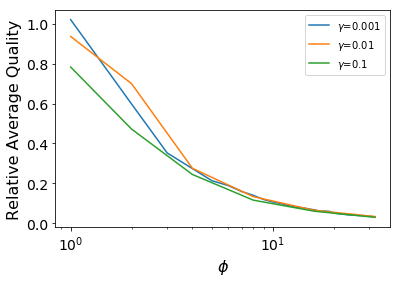

In [18]:
# PLOT AVG_Q vs PHI (deception)
plot_avg_quality(['phi.csv', 'phi_gamma0.01.csv', 'phi_gamma0.1.csv'], 
                 [r'$\gamma$'+'=0.001', r'$\gamma$'+'=0.01', r'$\gamma$'+'=0.1'], 
                 r'$\phi$', path='../EmpiricalNet_followers/', log_flag=True)

## Experiments with targeting
Preferential targerting of bot followers: hubs, partisans, conservatives, misinfo spreaders, core?

## Experiments with fitted params
Fit empirical amplification and distributions, explore those parameter values